# Chapter 5: Field data study Rockeskyller Kopf
# JME1 Inversions


<div class="alert alert-success">
    
This Notebook only reproduces the results of ``Sata/Rockeskyll/Res_JME1``. Visualization in Notebook 5.4.

In [1]:
# %% IMPORTS
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import pygimli           as pg
import pygimli.meshtools as mt
import cmasher           as cmr
import functools
import warnings

from pygimli.viewer             import pv
from pygimli.physics            import ert
from scipy.interpolate          import griddata
from AZ_pygimli_3DTopo          import *
from PlotFunctions_Ch5          import *
from datetime                   import datetime
from JointEntropyClass          import JointEntropyInversion as JEI

warnings.filterwarnings("ignore")

### Parameters and names

In [2]:
fig_dir = 'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Figures/Ch-5/'
fn_dir  = 'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Data/Rockeskyll/'

fn_mesh = 'invmesh.bms'

fn_magnetic = 'Magnetic_data_corrected.csv'

fn_all = 'ert_data_rockes_all'

n_lines = 4 # number of lines
idx_list = [0, 2055, 4134, 5906, 7694] # for Pseudosection display

# PARAMETERS (based on Boxberg 2011)
F = 48487.4   # Median field intensity in nT

SEED = 420 # Random seed to ensure reproduceability

# Plotting
c_ert = 'gnuplot'
c_mag = cmr.tropical
lim_pseudos = [18,180]

### Importing Magnetic Data and Geometry

In [3]:
# %% READING DATA CSV-FILE
df = pd.read_csv(fn_dir+fn_magnetic, delimiter=',', decimal='.')
d_obs = df['F'].to_numpy()-F                                           # Total Field Anomaly numpy array
pnts = np.array([[df['X'][i], df['Y'][i], df['Z'][i]] for i in range(len(df))])

### Importing ERT Data

Text(0.5, 1.0, 'ERT Data')

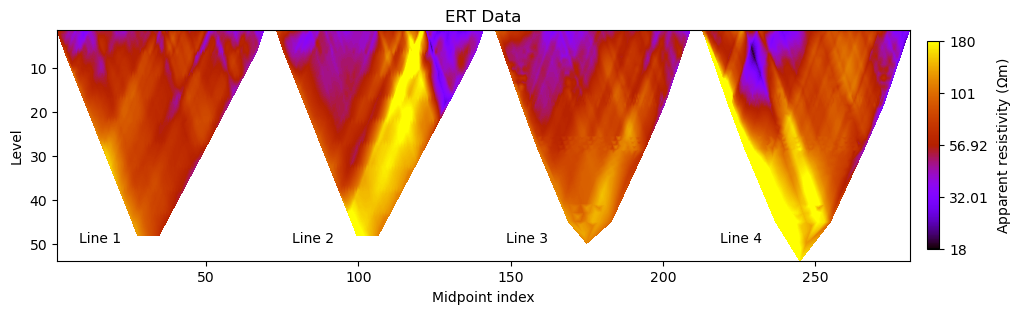

In [4]:
d_ert    = ert.load(fn_dir+fn_all)

# PLOT PSEUDOSECTIONS
%matplotlib inline
fig, ax = plt.subplots(figsize=(11,3))
showPseudosections(d_ert, d_ert['rhoa'].array(), idx_list, 4, ax=ax, clim=lim_pseudos, cmap=c_ert)
ax.set_title('ERT Data')

## Load Mesh

In [5]:
mesh = pg.load(fn_dir+fn_mesh)
mesh

Mesh: Nodes: 8381 Cells: 40005 Boundaries: 83717

### Magnetics Inout

In [ ]:
# Setup Inversion Manager
MAG, d_mag, relError = createMagManager(mesh, df)

In [ ]:
# Create Starting model
startModel = pg.Vector(mesh.cellCount(), 1e-4) # surrounding rock has susceptibility of around 0.0001

### JME Inversion

There are 4 different 
JME1 runs included in the thesis. Due to high computational demands (at least 30GM memory, takes like 2h with 16 cores) all joint inversions were performed on the Jupyter HPC Cluster. The inversion results can be replicated using the following settings:

<div class="alert alert-success">
    
**Res_JME1_1_1**<br>
``q = 1``<br>
``a = [35, 50]``<br>
``lam_e = 0.005``<br>
``lam_m = 0.05``<br>
``beta = 1e-10``<br>
``mw = [1,1]``<br>
``maxIter = 20``<br>
``chi_limit=13``
</div>

<div class="alert alert-success">
    
**Res_JME1_100_1**<br>
``q = 1``<br>
``a = [35, 50]``<br>
``lam_e = 0.005``<br>
``lam_m = 0.05``<br>
``beta = 1e-10``<br>
``mw = [100,1]``<br>
``maxIter = 20``<br>
``chi_limit=13``
</div>

<div class="alert alert-success">
    
**Res_JME1_1_100**<br>
``q = 1``<br>
``a = [35, 50]``<br>
``lam_e = 0.005``<br>
``lam_m = 0.05``<br>
``beta = 1e-10``<br>
``mw = [1,100]``<br>
``maxIter = 20``<br>
``chi_limit=13``
</div>

<div class="alert alert-success">
    
**Res_JME1_10_1**<br>
``q = 1``<br>
``a = [35, 50]``<br>
``lam_e = 0.005``<br>
``lam_m = 0.05``<br>
``beta = 1e-10``<br>
``mw = [10,1]``<br>
``maxIter = 20``<br>
``chi_limit=13``
</div>

In [ ]:
# %% Run inversion
q = 1
a = [35, 50]
lam_e = 0.005
lam_m = 0.05
beta = 1e-10
mw = [10,1]
maxIter = 20
chi_limit=13

np.random.seed(SEED)

inv = pg.Inversion(fop=fop, verbose=True)
inv.setRegularization(limits=[0, 0.15])  # to limit values, diatreme should have around 0.1
startModel = pg.Vector(mesh.cellCount(), 1e-4) # surrounding rock has susceptibility of around 0.0001
MAG = pg.frameworks.methodManager.MethodManager(fop=fop, fw=inv, data=d_mag)

ERT = ert.ERTManager(d_ert)

Jem = JEI(mgr_list=[ERT, MAG], data_list=[d_ert, d_mag], mesh=mesh, order=q, beta=beta, smooth_factor=a)

KWe = dict(lam=lam_e, verbose=True, limits=[1, 5e4])
KWm = dict(lam=lam_m, startModel=startModel, verbose=True, err=relError, limits=[0, 0.15])
Jem.setKWInv([KWe, KWm])
Jem.setMethodWeights(mw)
Jem.setNames(['ERT', 'MAG'])

start_jme = datetime.now()
Jem.runInversion('ME', maxIter=maxIter, chi_limit=13)
end_jme =  datetime.now()
jme_duration = end_jme-start_jme
print(f'JME Inversion took: {jme_duration}')

[r,s] = Jem.getModels()

In [ ]:
Jem.plotFitHistory()

fig, ax = showMagResult(pnts,MAG.inv)
fig.suptitle(f'q={q}, a={a[1]}, lam_m={lam_m}, mw_m={mw[1]}')

misfit =  100*(d_ert['rhoa'].array()-ERT.inv.response.array())/d_ert['rhoa'].array()

# PLOT PSEUDOSECTIONS
fig, ax = plt.subplots(figsize=(10, 3.3))
showPseudosections(d_ert, misfit, idx_list, 4, ax=ax, cmap='coolwarm', clim=[-30, 30], Type='misfit')
fig.suptitle(f'q={q}, a={a[0]}, lam_e={lam_e}, mw_e={mw[0]}')
plt.savefig(f'Res_JME{q}/Ert_result.pdf', dpi=600, tight_layout=True)